<a href="https://colab.research.google.com/github/sadiabristi/AI-LAB/blob/main/Medical_cost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Import packages**

In [9]:
# We installed a missing values viewer.
!pip install missingno

In [10]:
# We installed the package to perform factor analysis.
!pip install prince

# **2. Import libraries**

In [11]:
## Handling data
import pandas as pd
import numpy as np
pd.set_option('display.max_columns',None)

## Visualization data
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
plt.style.use('ggplot')
sns.set_style('whitegrid')

## Stats
from scipy.stats import shapiro
from statsmodels.graphics.gofplots import qqplot

## Visualization missing values
import missingno as ms

## Factorial Analysis
from prince import FAMD

## Preprocessing
from sklearn.model_selection import train_test_split as tts
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

## Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

## Metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Time
import time

## typing
from typing import List, Dict

## Warnings
import warnings
warnings.filterwarnings('ignore')

# **3. Load data**

In [12]:
data = pd.read_csv('medical_cost.csv')
data.head()

,Id,age,sex,bmi,children,smoker,region,charges
0,1,19,female,27.900,0,yes,southwest,16884.92400
1,2,18,male,33.770,1,no,southeast,1725.55230
2,3,28,male,33.000,3,no,southeast,4449.46200
3,4,33,male,22.705,0,no,northwest,21984.47061
4,5,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [13]:
# Eliminate the 'Id' since it does not add value.
data.drop('Id', axis = 1, inplace = True)

In [14]:
# Data size
print(f"El conjunto de datos tiene {data.shape[0]} filas y {data.shape[1]} columnas")

El conjunto de datos tiene 1338 filas y 7 columnas


In [15]:
# Data set information
print("=="*30)
print("  "*10, "Data set Information")
print("=="*30)
print(data.info())

                     Data set Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None


# **4. EDA**

In [16]:
# We check the number of duplicate rows.
print(f'There are {data.duplicated().sum()} duplicate rows')

There are 1 duplicate rows


We visualize that there is a duplicate row, we will proceed to eliminate it.

In [17]:
# Delete the duplicate row.
data.drop_duplicates(inplace=True)

In [18]:
# Check again that the duplicate row does not exist.
print(f'There are {data.duplicated().sum()} duplicate rows')

There are 0 duplicate rows


Great!!, we no longer have duplicate rows.

In [19]:
# Now check for the presence of null values.
data.isnull().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


Perfect, it's good not to have missing values.

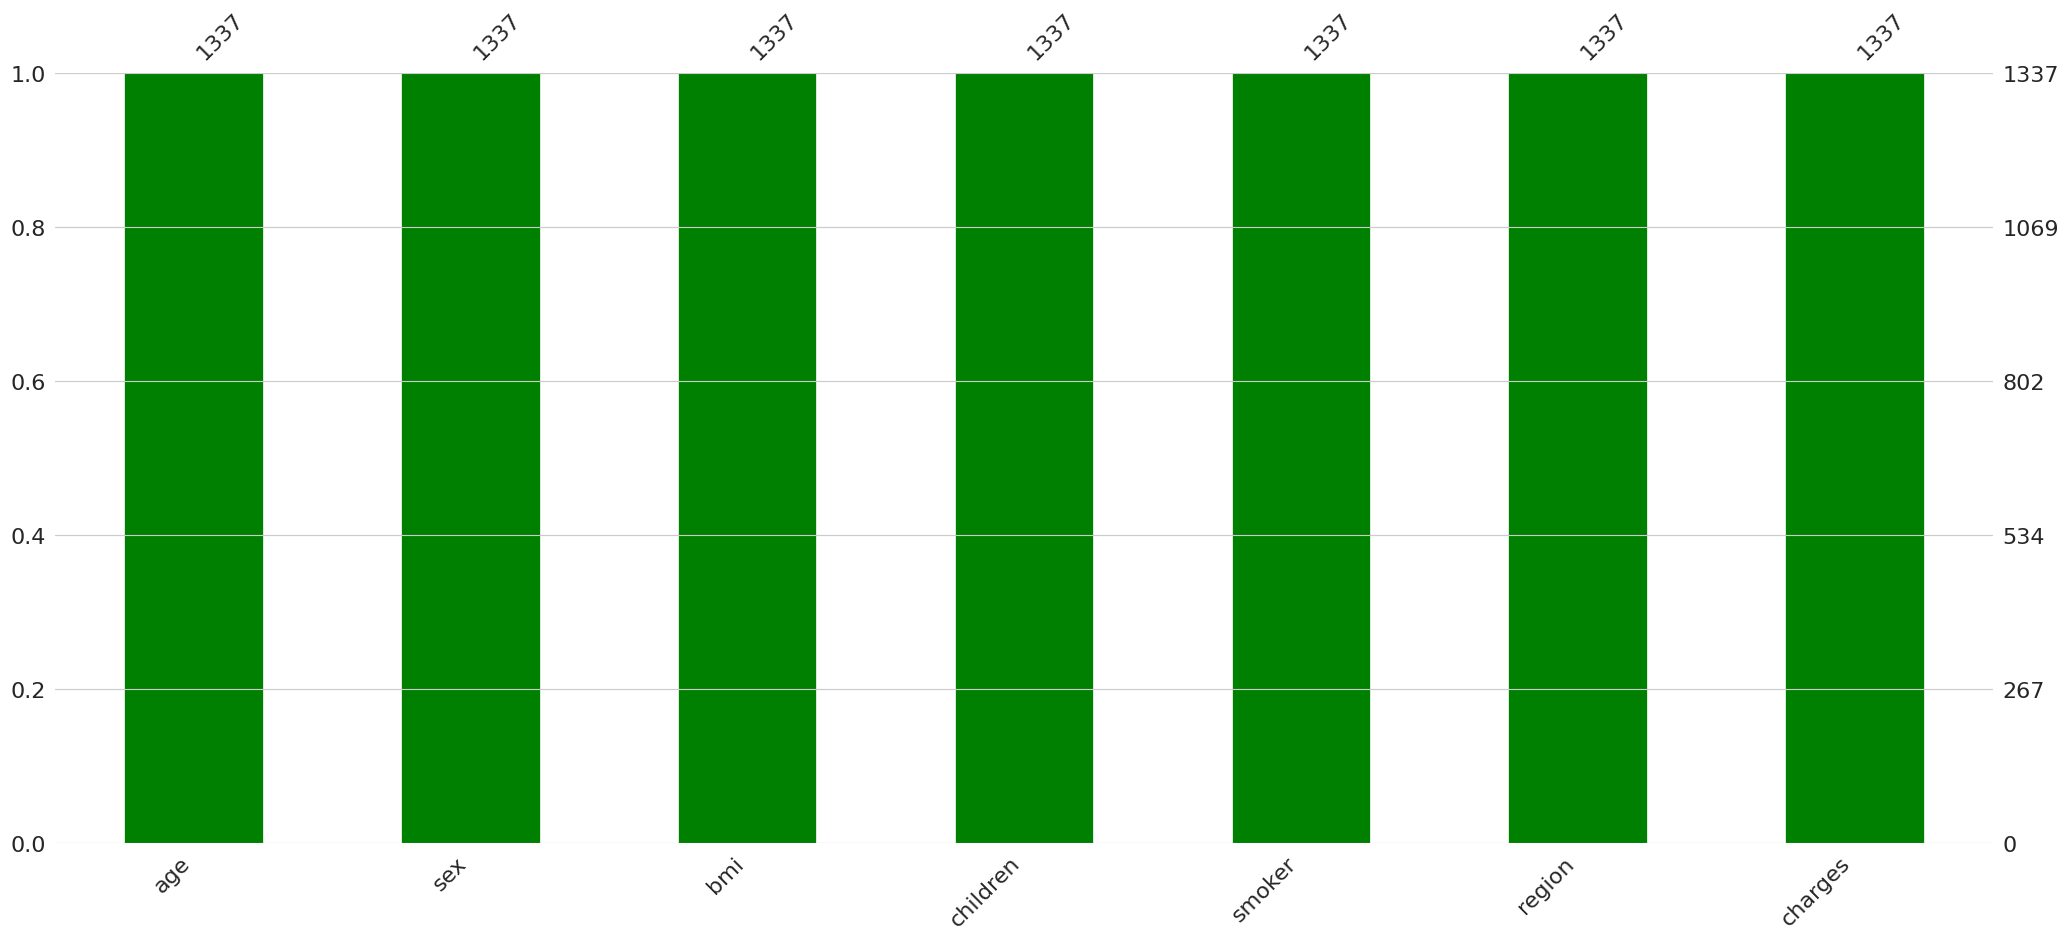

In [20]:
# Now we visualize the non-existence of null values.
ms.bar(data, color = 'green')
plt.show()

In [21]:
## We now select the numeric and categorical variables from our data set to plot.
num_cols = data.select_dtypes(include = ['int','float']).columns.to_list()
cat_cols = data.select_dtypes(include = ['object', 'category']).columns.to_list()

# We will show the categorical variables with their respective values.
print('=='*40)
print(f'Total Categorical Variables = {len(cat_cols)}')
print('Categorical Variable => Unique values => Total unique values')
print('=='*50)
for cat in cat_cols:
    print('*',cat,'==>',data[cat].unique(),'==>',data[cat].nunique(),'\n')

# We show the numeric variables.
print('=='*30)
print(f'Total Numerical Variables = {len(num_cols)}')
print(f'Numerical Variable')
print('=='*30)
for num in num_cols:
  print('*',num)

Total Categorical Variables = 3
Categorical Variable => Unique values => Total unique values
* sex ==> ['female' 'male'] ==> 2 

* smoker ==> ['yes' 'no'] ==> 2 

* region ==> ['southwest' 'southeast' 'northwest' 'northeast'] ==> 4 

Total Numerical Variables = 4
Numerical Variable
* age
* bmi
* children
* charges


We proceed to perform a univariate analysis.



# **4.1 Univariate Analysis**

In [22]:
## We define our function to check if our numerical data comes from a normal distribution.
# We will use the Shapiro test.
def shapiro_test(data:pd.DataFrame, col:str):
  stat,p_value = shapiro(data[col])
  if p_value < 0.05:
    return p_value, 'No Normal Ditribution'
  else:
    return p_value, 'Normal Distribution'

In [23]:
def univariate_numerical_plot(data:pd.DataFrame, var:str):
  """
  Args:
    - data(pd.DataFrame): data.
    - var(str): variable to plot.
  """
  ax = plt.figure(constrained_layout = False, figsize = (12,5.8)).subplot_mosaic("""AD
                                                                                 BD""")
  sns.boxplot(data, x= var, ax = ax['A'], color = 'green')
  sns.stripplot(data, x = var, alpha = 0.5, color = 'blue', ax = ax['A'])
  sns.histplot(data, x = var, kde = True,line_kws = {'linewidth':2.2}, color = 'red', ax = ax['B'])
  qqplot(data[var], line = 's', ax = ax['D'])
  df_info = data[var].describe()
  ax['A'].set_xlabel('')
  ax['A'].set_title(f'Mean={round(df_info[1],2)} | Std={round(df_info[2],2)} | Median={round(df_info[5],2)}', fontsize = 9, fontweight='bold')
  ax['B'].set_xlabel('')
  ax['D'].set_title(f'QQ-Plot | Shapiro test: p-value={round(shapiro_test(data,var)[0],3)} | {shapiro_test(data,var)[1]}',fontsize=9, fontweight='bold')
  plt.suptitle(f'Numerical Variable: {var}', fontsize = 14, fontweight = 'bold', color = 'darkred')
  plt.tight_layout()
  plt.subplots_adjust(top=0.9)
  plt.show()

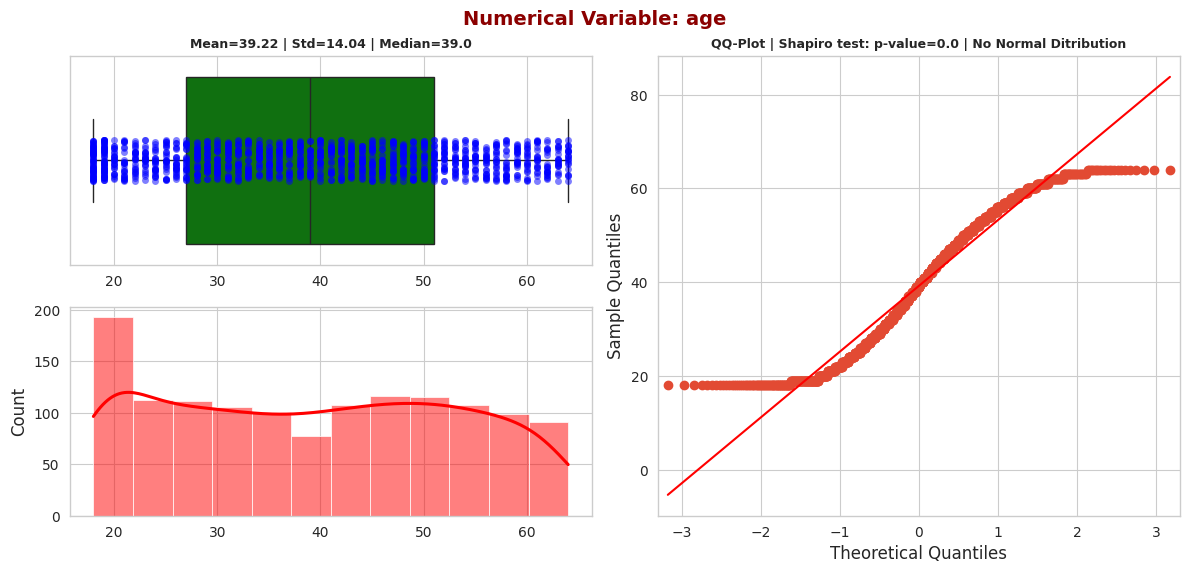

In [24]:
univariate_numerical_plot(data, num_cols[0])

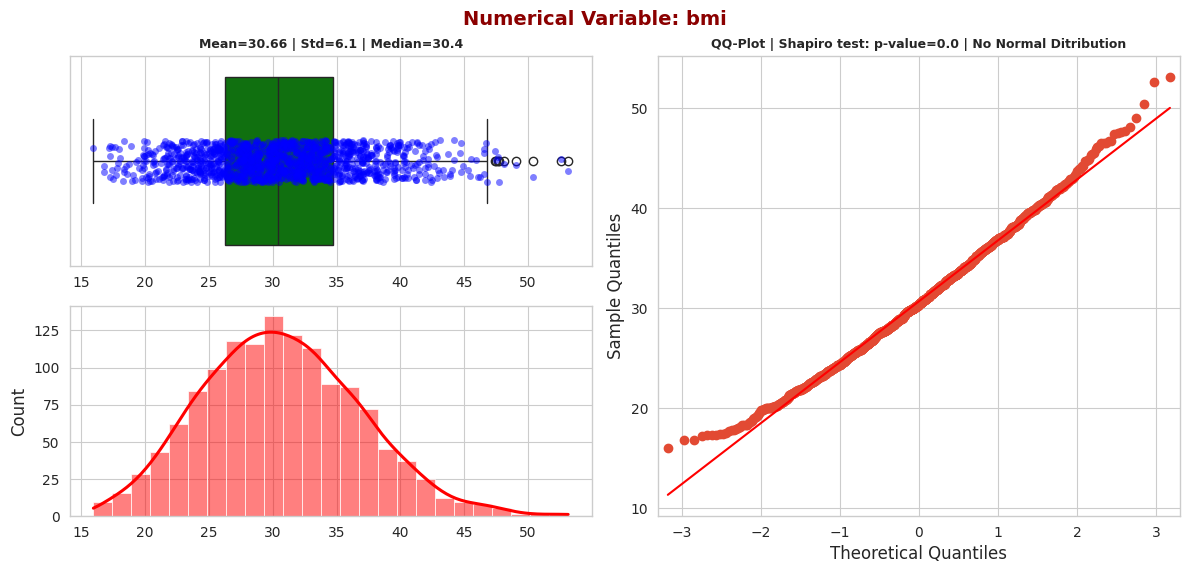

In [25]:
univariate_numerical_plot(data, num_cols[1])

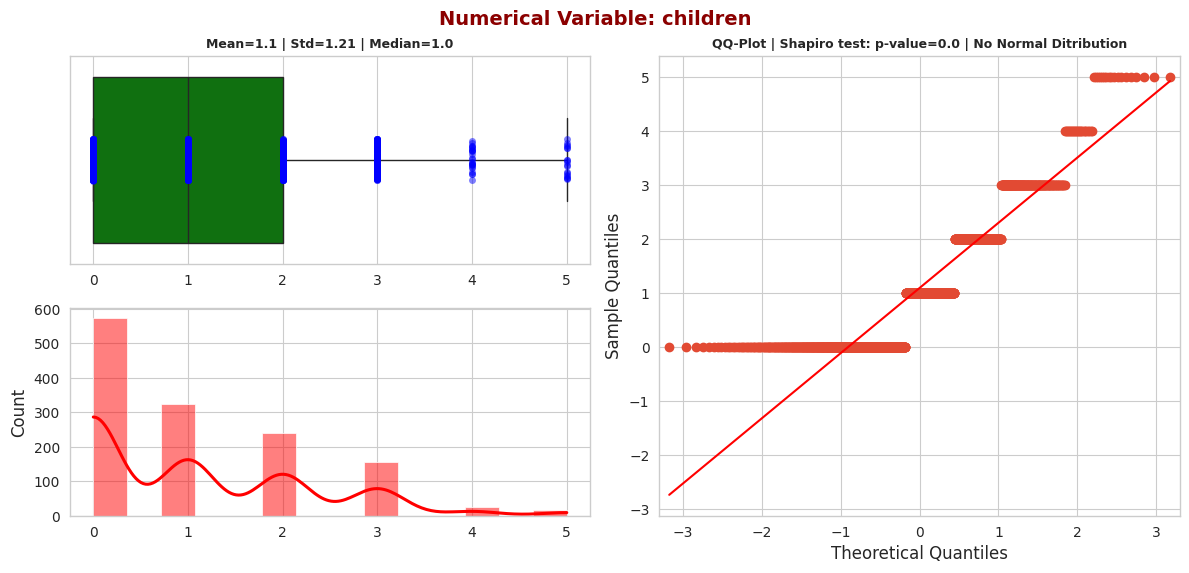

In [26]:
univariate_numerical_plot(data, num_cols[2])

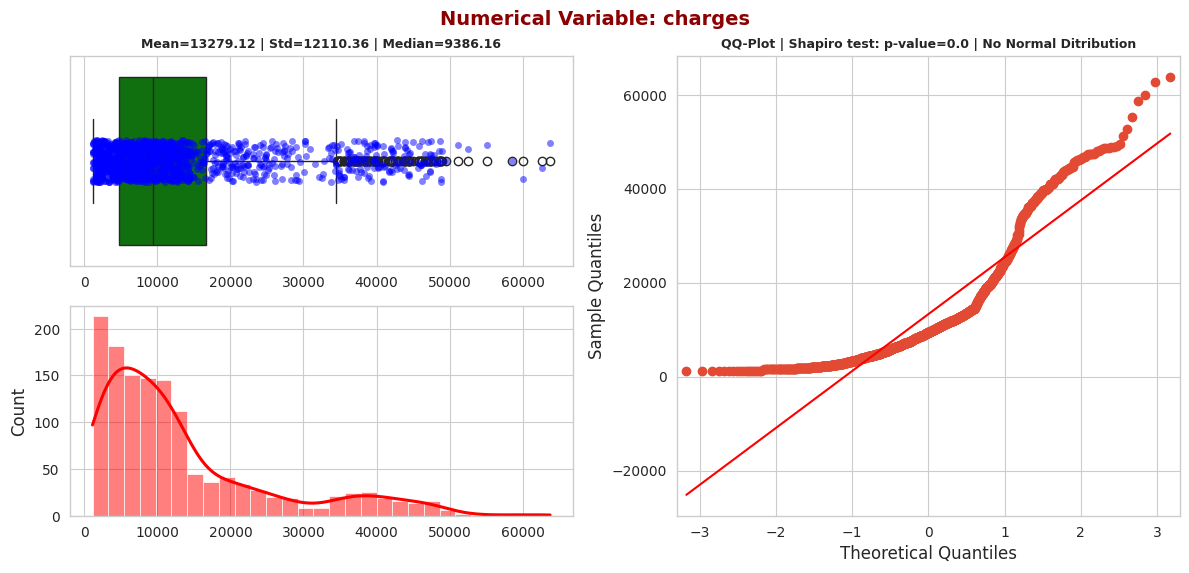

In [27]:
univariate_numerical_plot(data, num_cols[3])

In [28]:
# Let's visualize a descriptive statistic of our numerical data.
data[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
age,1337.0,39.222139,14.044333,18.0000,27.000,39.0000,51.00000,64.00000
bmi,1337.0,30.663452,6.100468,15.9600,26.290,30.4000,34.70000,53.13000
children,1337.0,1.095737,1.205571,0.0000,0.000,1.0000,2.00000,5.00000
charges,1337.0,13279.121487,12110.359656,1121.8739,4746.344,9386.1613,16657.71745,63770.42801


In [29]:
def univariate_categorical_plot(data:pd.DataFrame, col:str):

  # We define the size of our figure.
  fig,ax = plt.subplots(1,2,figsize=(12,4))

  # 1. We create our dataframe that contains our data to be displayed.
  df_plot = data[col].value_counts().to_frame()
  # 2. We generate the values ​​of our graphs.
  values = df_plot.iloc[:,0]
  # 3. We generate the labels for our charts.
  labels = df_plot.index
  # 4. We generate the color map.
  cmap = plt.get_cmap('tab20')
  # 5. Get colors.
  colors = cmap(np.arange(len(labels)))

  # 2. Bar chart.
  rects = ax[0].bar(labels, values, color = colors,
                    edgecolor = 'black', linewidth = 2.0)
  ax[0].set_ylabel('Count', fontsize = 12, fontweight = 'bold', color = 'black')
  ax[0].set_xticklabels(df_plot.index, fontsize = 10, fontweight = 'bold')

  # function to label our bars.
  def autolabel(rects):
    for rect in rects:
      height = rect.get_height()
      ax[0].annotate(text = '{}'.format(height),
                  xy = (rect.get_x() + rect.get_width()/2., height-0.005),
                  xytext = (0,3),
                  textcoords = 'offset points',
                  va = 'bottom',
                  ha = 'center',
                  weight = 'bold',
                  size = 9,
                  color = 'black')

  autolabel(rects) # we label our bars.


  # 3. Pie chart.
  ax[1].pie(x = values, labels = labels , startangle = 90,
            autopct = '%.1f%%', colors = colors, wedgeprops={'linewidth':2,'edgecolor':'black'},
            textprops = {'color':'black', 'weight':'bold','fontsize':10})
  ax[1].axis('equal')

  # Title of our figure.
  fig.suptitle(f"Categorical variable: {col}", fontsize = 14, fontweight = 'bold', color = 'darkred')

  fig.tight_layout()
  fig.subplots_adjust(top = 0.9)
  fig.show()


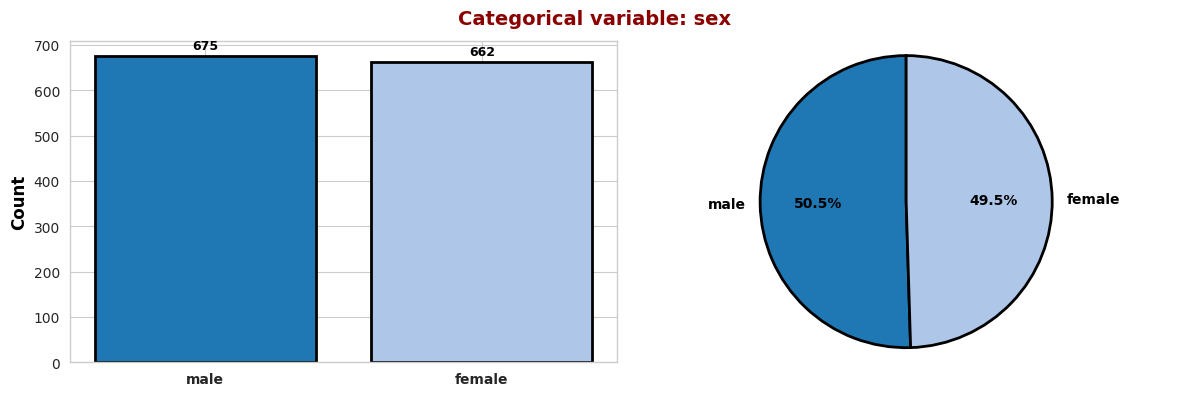

In [30]:
univariate_categorical_plot(data, cat_cols[0])

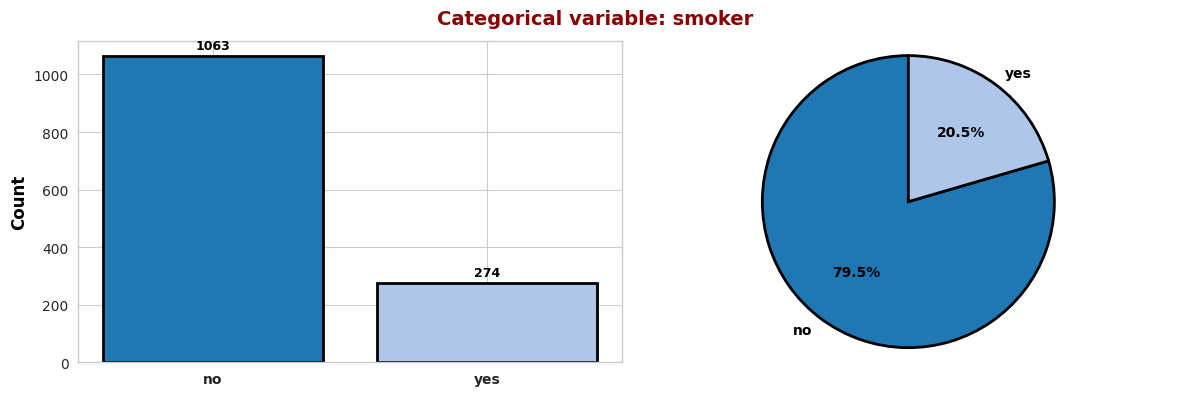

In [31]:
univariate_categorical_plot(data, cat_cols[1])

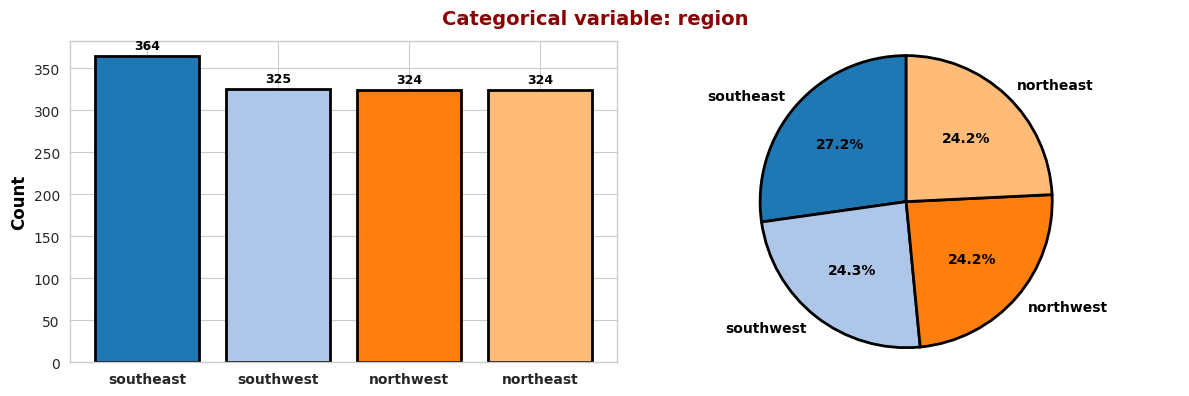

In [32]:
univariate_categorical_plot(data, cat_cols[2])

We now turn to a bivariate analysis.

# **4.2 Bivariate Analysis**

In [33]:
def bivariate_categorical_plot(data:pd.DataFrame, col_1:str, col_2:str):
  # We create our dataframe
  df_bi = pd.crosstab(data[col_1], data[col_2])
  labels = df_bi.index # labels
  values_1 = df_bi.iloc[:,0].values # values ​​in the bottom bar.
  values_2 = df_bi.iloc[:,1].values # values ​​in the top bar.

  # We define the size of our figure.
  fig,ax = plt.subplots(figsize = (8,4))
  # 1. Bottom bar graph.
  ax.bar(labels, values_1, label = df_bi.columns[0], color = 'red',
        linewidth = 2.0, edgecolor = 'black')
  # 2. Upper bar chart.
  ax.bar(labels,values_2, bottom = values_1, label = df_bi.columns[1], color = 'blue',
        linewidth = 2.0, edgecolor = 'black')
  ax.set_ylabel('Count', fontsize = 12, fontweight = 'bold', color = 'black')
  ax.set_xticklabels(labels, fontsize = 10, fontweight = 'bold')
  ax.set_title(f'{col_2} distribution by {col_1}', fontsize = 10, fontweight = 'bold', color = 'darkred')
  # We label our bars.
  for bar in ax.patches:
    ax.text(bar.get_x() + bar.get_width() / 2,
            bar.get_height() / 2 + bar.get_y(),
            round(bar.get_height()), ha = 'center',
            color = 'w', weight = 'bold', size = 10)

  ax.legend()
  fig.show()


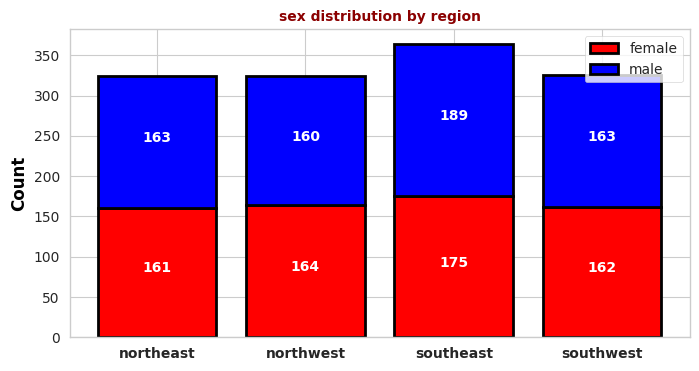

In [34]:
bivariate_categorical_plot(data, cat_cols[2], cat_cols[0])

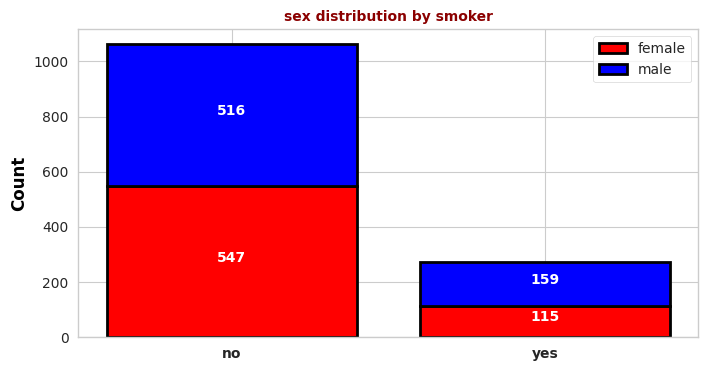

In [35]:
bivariate_categorical_plot(data, cat_cols[1], cat_cols[0])

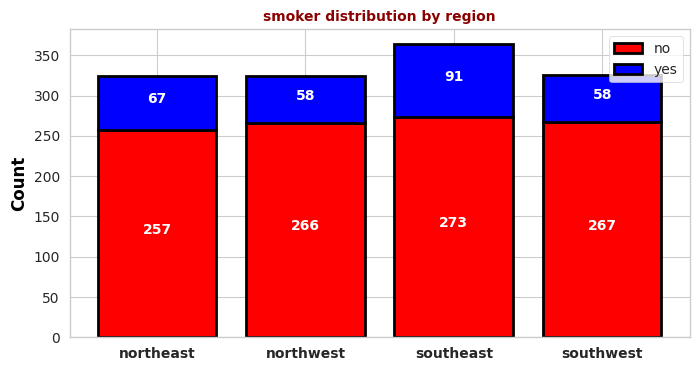

In [36]:
bivariate_categorical_plot(data, cat_cols[2], cat_cols[1])

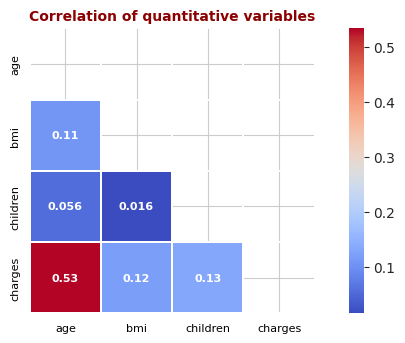

In [37]:
# Chart of correlations between quantitative variables.
corr_matrix = data[num_cols].corr(method='spearman') # we use spearman since the numerical variables do not follow a normal distribution.
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

fig,ax = plt.subplots(figsize=(9,3.7))
sns.heatmap(corr_matrix,
            mask = mask,
            square = True,
            annot = True,
            ax = ax,
            linewidths = 0.2,
            annot_kws = {'size':8, 'fontweight':'bold'},
            cmap='coolwarm')
ax.tick_params(labelsize=8, color = 'blue', labelcolor='black')
ax.set_title('Correlation of quantitative variables',fontsize = 10,fontweight='bold', color = 'darkred')
fig.show()

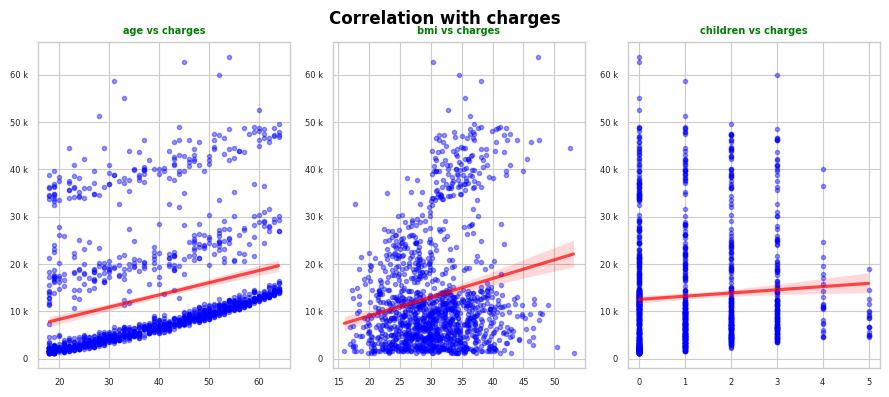

In [38]:
# Correlation plot between numerical variables and the target variable.
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 4))
axes = axes.flat
num_cols_modified = data.select_dtypes(include=['int','float']).columns.drop('charges').to_list()

for i, colum in enumerate(num_cols_modified):
    sns.regplot(
        x           = data[colum],
        y           = data['charges'],
        color       = "blue",
        marker      = '.',
        scatter_kws = {"alpha":0.4},
        line_kws    = {"color":"red","alpha":0.7},
        ax          = axes[i]
    )
    axes[i].set_title(f"{colum} vs charges", fontsize = 7, fontweight = "bold", color = 'green')
    axes[i].yaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].xaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

fig.suptitle('Correlation with charges', fontsize = 12, fontweight = "bold", color = 'black')
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.show()

In [39]:
def num_vs_cat_variables(data:pd.DataFrame, var_num:str, var_cat:str):

    ax = plt.figure(constrained_layout = False, figsize = (13,5.5)).subplot_mosaic("""AD
                                                                               BD""")
    sns.boxplot(data, x = var_cat, y = var_num, ax = ax['D'])
    sns.stripplot(data, x = var_cat, y = var_num, alpha = 0.4, hue = var_cat, ax = ax['D'])
    sns.histplot(data, x = var_num, hue = var_cat, line_kws = {'linewidth':1.8}, ax = ax['B'])
    sns.kdeplot(data, x = var_num, fill = True, hue = var_cat, ax = ax['A'])
    ax['A'].set_xlabel('')
    ax['B'].set_xlabel('')
    plt.suptitle(f'Distribution of {var_num} variable by {var_cat}',fontsize = 14, fontweight = 'bold', color = 'darkred')
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

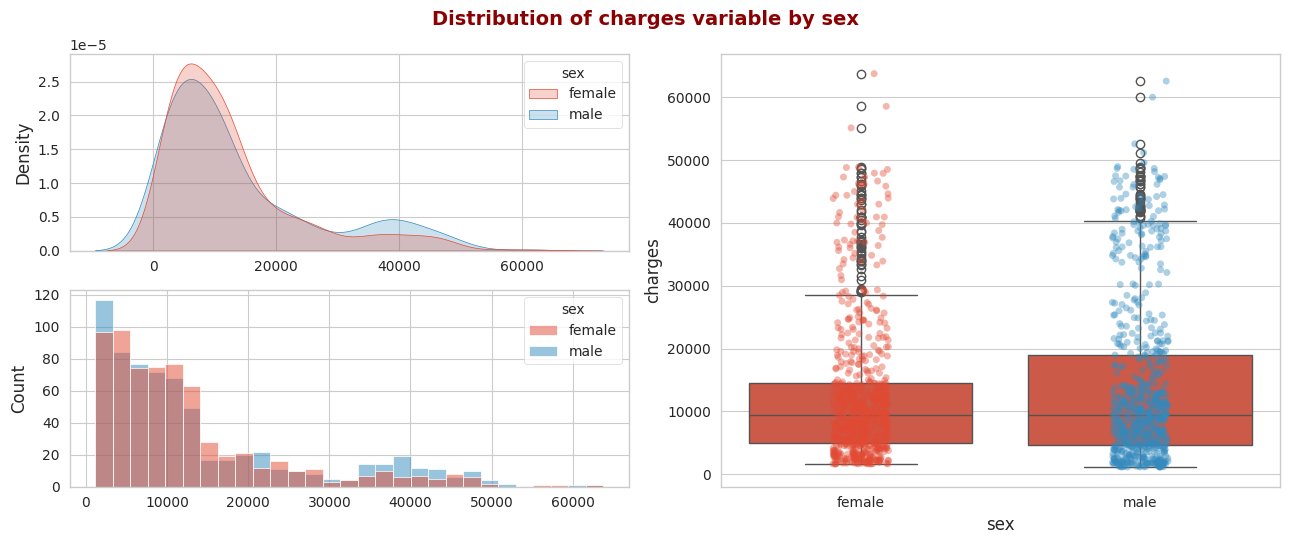

In [40]:
num_vs_cat_variables(data, num_cols[3], cat_cols[0])

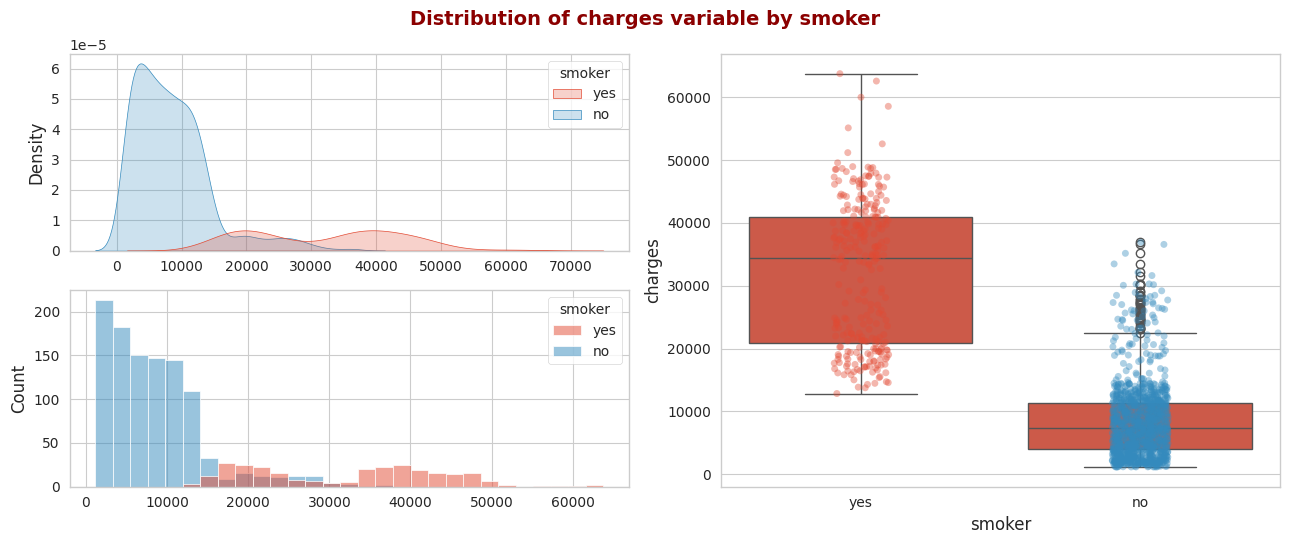

In [41]:
num_vs_cat_variables(data, num_cols[3], cat_cols[1])

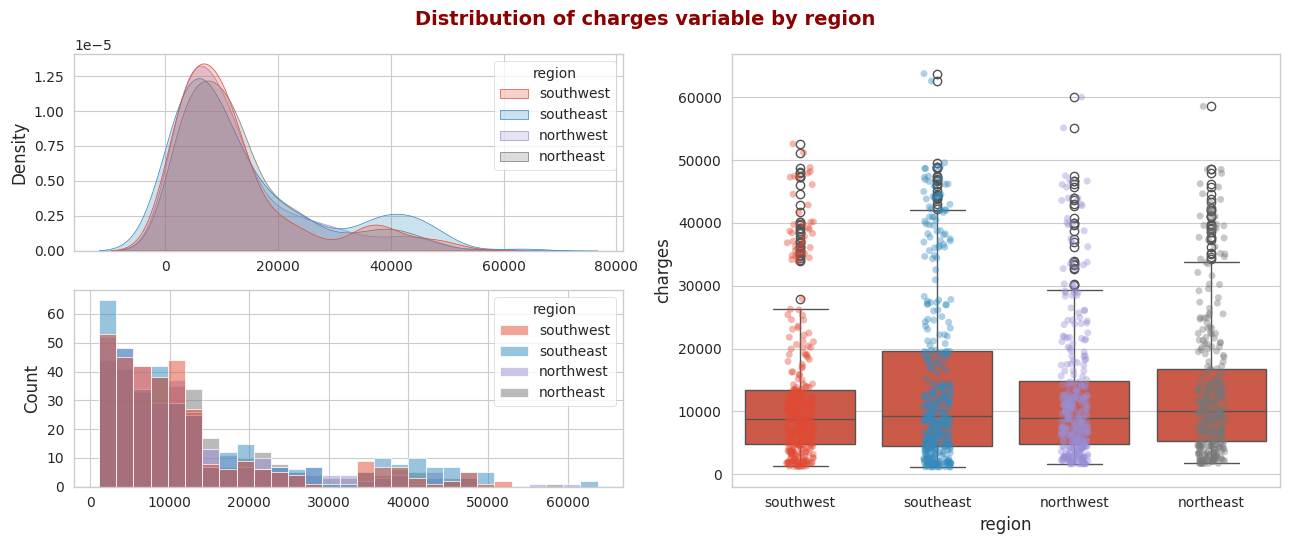

In [42]:
num_vs_cat_variables(data, num_cols[3], cat_cols[2])

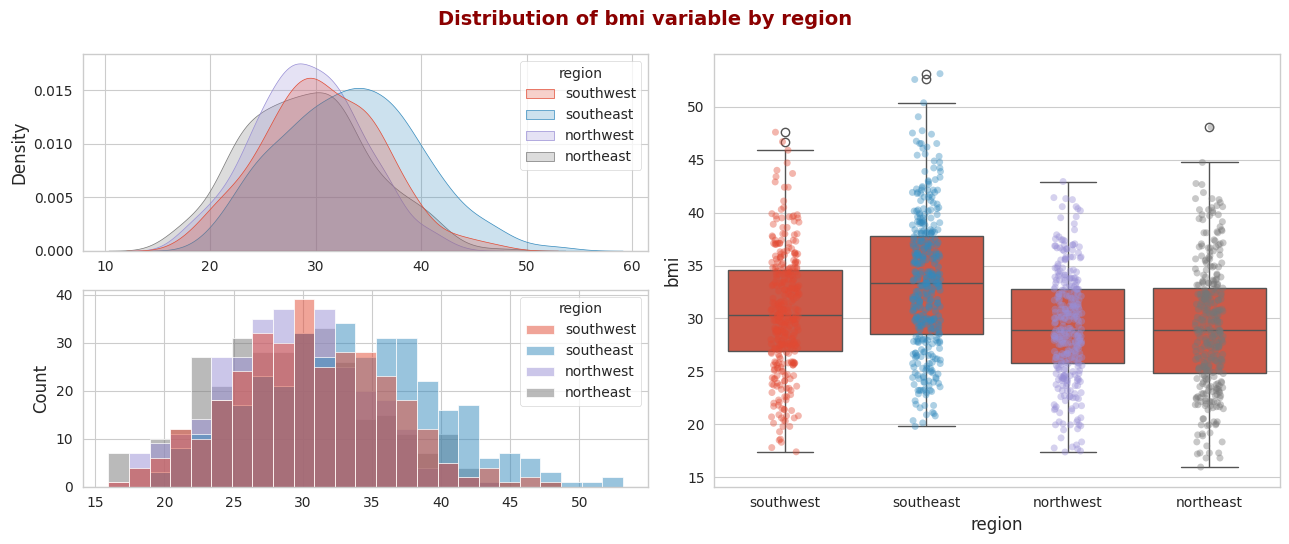

In [43]:
num_vs_cat_variables(data, num_cols[1], cat_cols[2])

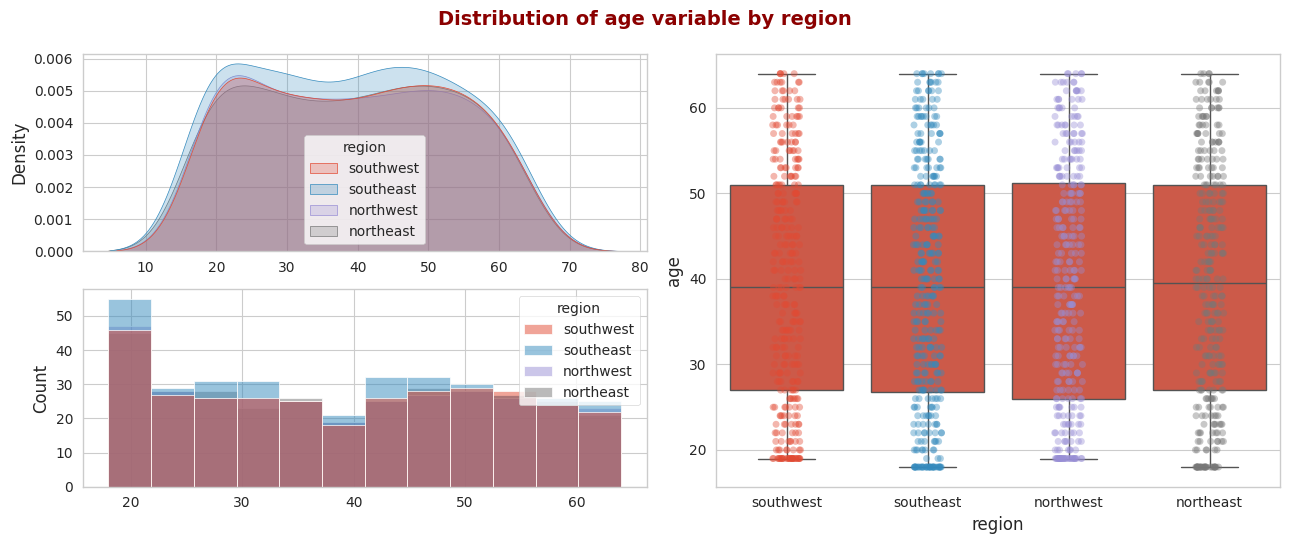

In [44]:
num_vs_cat_variables(data, num_cols[0], cat_cols[2])

Now let's move on to perform a multivariate analysis.

# **4.3 Multivariate Analysis**

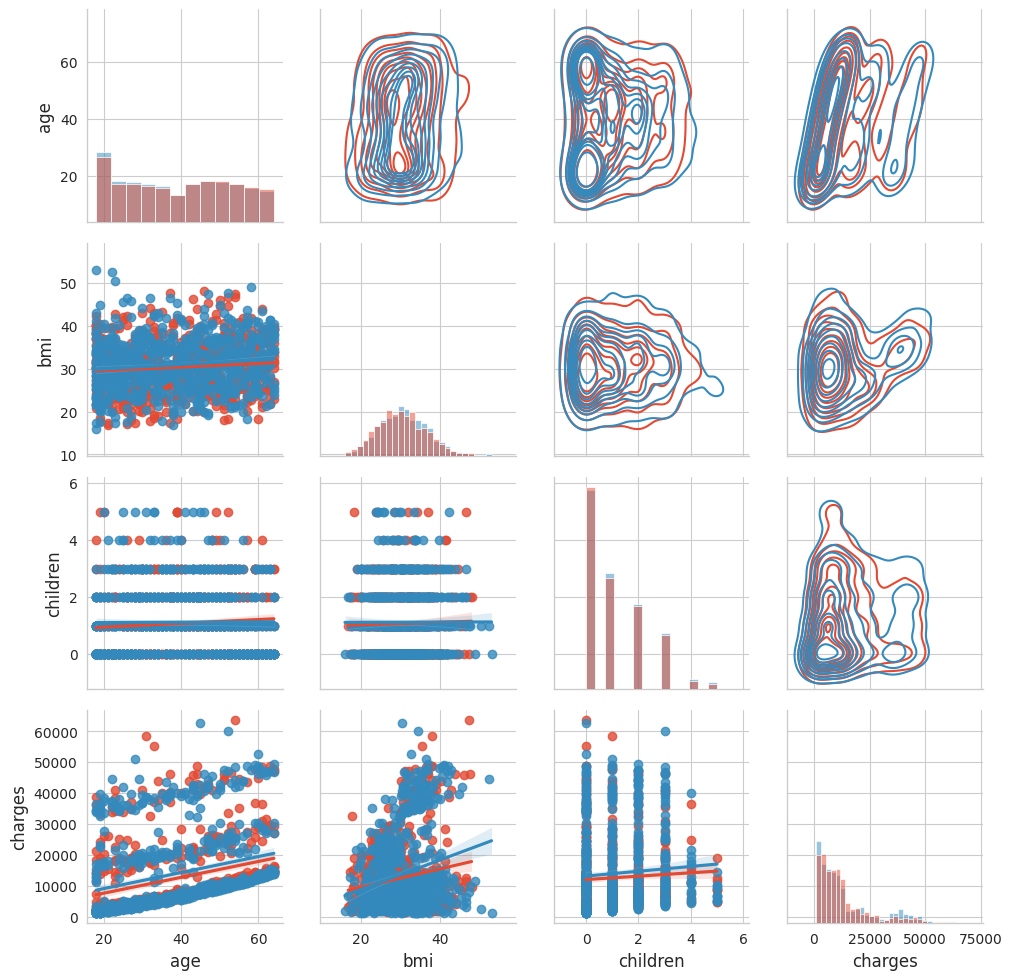

In [45]:
g = sns.PairGrid(data, hue = 'sex')
g.map_diag(sns.histplot)
g.map_lower(sns.regplot)
g.map_upper(sns.kdeplot, cmap = 'magma')
g.fig.show()

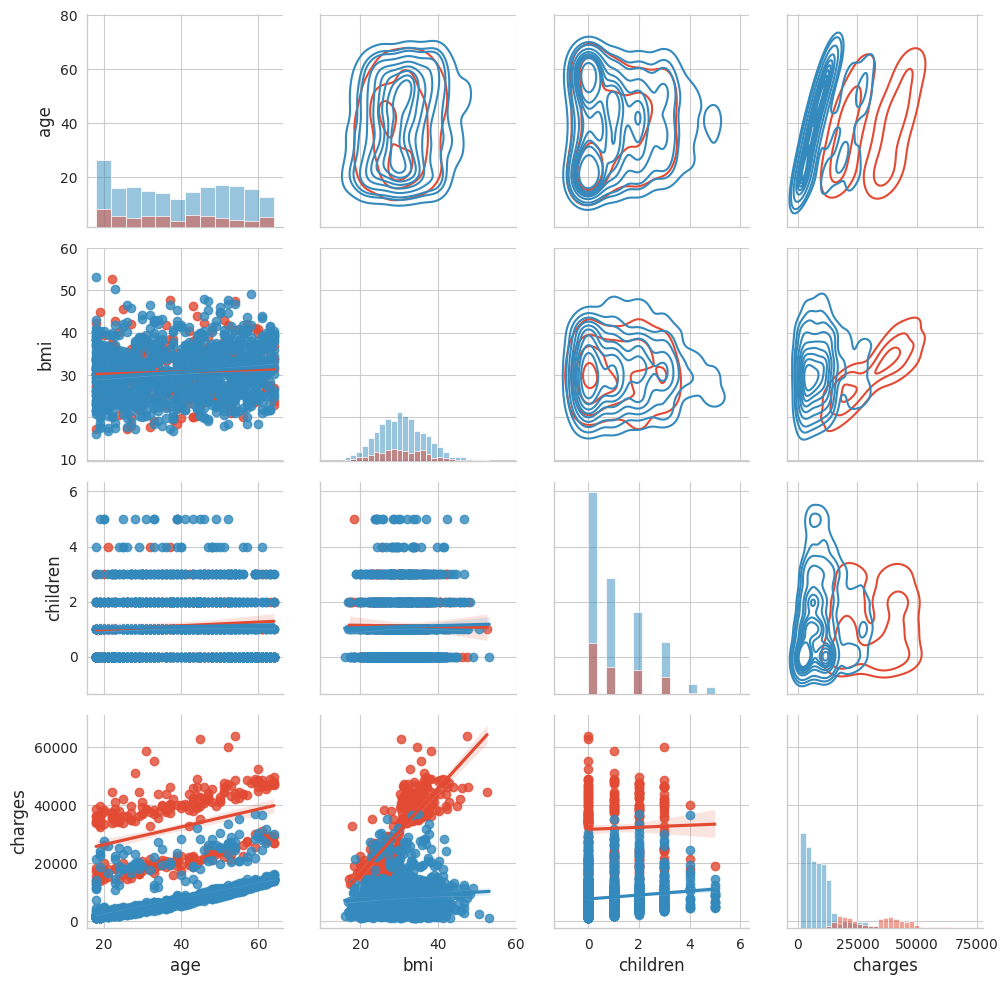

In [46]:
g = sns.PairGrid(data, hue = 'smoker')
g.map_diag(sns.histplot)
g.map_lower(sns.regplot)
g.map_upper(sns.kdeplot)
g.fig.show()

In [47]:
## Factor Analysis Mixed Data(FAMD)

# 1. We create a copy of our data.
data_copy = data.copy()
# 2. We initialize our scaler in this case StandardScaler.
scaler = StandardScaler()
# 3. We fit and transform on our numerical data.
X_num_scaler = scaler.fit_transform(data_copy[num_cols])
# 4. We assign our scaled data to our dataframe.
data_copy[num_cols] = X_num_scaler
# 5. We visualize our set with scaled numeric data.
data_copy.head()

,age,sex,bmi,children,smoker,region,charges
0,-1.440418,female,-0.453160,-0.909234,yes,southwest,0.297857
1,-1.511647,male,0.509422,-0.079442,no,southeast,-0.954381
2,-0.799350,male,0.383155,1.580143,no,southeast,-0.729373
3,-0.443201,male,-1.305052,-0.909234,no,northwest,0.719104
4,-0.514431,male,-0.292456,-0.909234,no,northwest,-0.777499


In [48]:
# 6. Instantiate the FAMD class.
famd = FAMD(n_components = 2, # two components
            n_iter = 10, # 10 iter
            random_state = 42)
famd.fit(data_copy)

FAMD(n_iter=10, random_state=42)

In [49]:
# 7. We visualize the eigenvalues ​​and the amount of information conserved in two dimensions.
famd.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,2.348,20.42%,20.42%
1,1.645,14.31%,34.72%


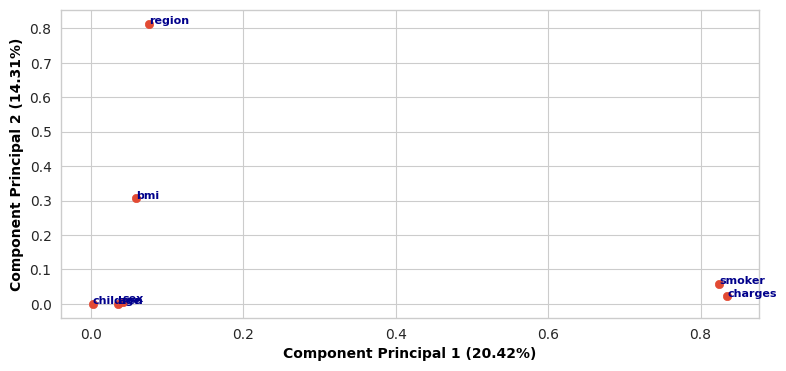

In [50]:
# Plot the coordinates of the variables in the principal component space.
fig,ax = plt.subplots(figsize=(9,4))
ax.scatter(famd.column_coordinates_[0], famd.column_coordinates_[1])

# Label the points with the name of the variables.
for i, txt in enumerate(famd.column_coordinates_.index):
    ax.annotate(txt, (famd.column_coordinates_[0][i], famd.column_coordinates_[1][i]), size = 8, color = 'darkblue', fontweight = 'bold')


# Add axis labels.
ax.set_xlabel(f'Component Principal 1 ({famd.eigenvalues_summary.iloc[0,1]})', fontsize = 10, fontweight = 'bold', color = 'black')
ax.set_ylabel(f'Component Principal 2 ({famd.eigenvalues_summary.iloc[1,1]})', fontsize = 10, fontweight = 'bold', color = 'black')

# show plot
ax.grid(True)
fig.show()

# **5. Preprocessing**

In [51]:
# We divided our data set into independent and dependent (target) variables.
X = data.drop('charges', axis = 1)
y = data['charges'] # target

# We divided into training and test set.
# We define our random seed for reproducibility.
SEED = 123
X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.2, shuffle = True, random_state = SEED)

In [52]:
## We visualize the size of each data set
print('=='*20)
print('Training set size')
print('=='*20)
print(f'X_train ==> {X_train.shape[0]} rows and {X_train.shape[1]} columns')
print(f'y_train ==> {y_train.shape[0]} rows and 1 column\n')
print('=='*20)
print('Testing set size')
print('=='*20)
print(f'X_test ==> {X_test.shape[0]} rows and {X_test.shape[1]} columns')
print(f'y_test ==> {y_test.shape[0]} rows and 1 column')

Training set size
X_train ==> 1069 rows and 6 columns
y_train ==> 1069 rows and 1 column

Testing set size
X_test ==> 268 rows and 6 columns
y_test ==> 268 rows and 1 column


In [53]:
# We convert our target variable to float32 data type
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

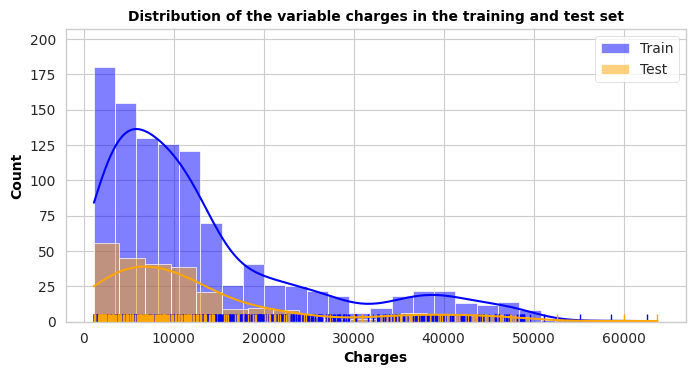

In [54]:
# Now we visualize the distribution of our dependent variable (target) in the training and test set.

fig,ax = plt.subplots(figsize = (8,3.8))
sns.histplot(y_train, kde = True, color = 'blue', label = 'Train', ax = ax)
sns.rugplot(y_train, color = 'blue', ax = ax)
sns.histplot(y_test, kde = True, ax = ax, color = 'orange', label = 'Test')
sns.rugplot(y_test, ax = ax, color = 'orange')
ax.set_title('Distribution of the variable charges in the training and test set',fontsize=10,fontweight='bold', color = 'black')
ax.set_ylabel('Count', fontsize = 10, fontweight = 'bold', color = 'black')
ax.set_xlabel('Charges', fontsize = 10, fontweight = 'bold', color = 'black')
ax.legend()
fig.show()

In [55]:
## We select the categorical and numeric variables.

# Quantitative variables.
numerical_cols = X_train.select_dtypes(include=['int','float']).columns.to_list()

# Qualitative variables.
categorical_cols = X_train.select_dtypes(include=['object','category']).columns.to_list()

In [56]:
# We visualize the variables.
print(f'Numerical Variables: {numerical_cols}')
print(f'Categorical Variables: {categorical_cols}')

Numerical Variables: ['age', 'bmi', 'children']
Categorical Variables: ['sex', 'smoker', 'region']


In [57]:
## We create our preprocessor:
# - OneHotEncoder: categorical variables.
# - StandardScaler: numerical variables.
preprocessor = ColumnTransformer(transformers = [('ohe',OneHotEncoder(handle_unknown='ignore', sparse_output = False),categorical_cols),
                                                  ('std',StandardScaler(), numerical_cols)],
                                 remainder = 'passthrough', verbose_feature_names_out = False).set_output(transform = 'pandas')

## We fit and transform the training set.
X_train_prep = preprocessor.fit_transform(X_train)

## We transform the test set.
X_test_prep = preprocessor.transform(X_test)

## We visualize the size of each data set.
print('=='*25)
print(' '*5,'Training set size')
print('=='*25)
print(f'X_train ==> {X_train_prep.shape[0]} rows and {X_train_prep.shape[1]} columns\n')
print('=='*25)
print(' '*8,'Testing set size')
print('=='*25)
print(f'X_test ==> {X_test_prep.shape[0]} rows and {X_test_prep.shape[1]} columns')

      Training set size
X_train ==> 1069 rows and 11 columns

         Testing set size
X_test ==> 268 rows and 11 columns


**Functions to plot metrics**.

In [58]:
# Metrics for the training and testing set
def my_metrics(y_true_train:pd.Series, y_true_test:pd.Series,
               y_pred_train:np.ndarray, y_pred_test:np.ndarray):

  r2_train = round(r2_score(y_train, y_pred_train),3)
  mse_train = round(mean_absolute_error(y_train, y_pred_train),3)
  mae_train = round(mean_absolute_error(y_train, y_pred_train),3)
  rmse_train = round(np.sqrt(mse_train),3)

  r2_test = round(r2_score(y_test, y_pred_test),3)
  mse_test = round(mean_absolute_error(y_test, y_pred_test),3)
  mae_test = round(mean_absolute_error(y_test, y_pred_test),3)
  rmse_test = round(np.sqrt(mse_test),3)

  my_metrics_train = {'r2':r2_train, 'mse':mse_train, 'mae':mae_train, 'rmse':rmse_train}
  my_metrics_test = {'r2':r2_test, 'mse':mse_test, 'mae':mae_test, 'rmse':rmse_test}

  return my_metrics_train, my_metrics_test

In [59]:
# Plot metrics
def metrics_plot(my_metrics_train:dict, my_metrics_test:dict):
  metrics_train, metrics_test = my_metrics_train, my_metrics_test

  df_plot_metric_train = pd.DataFrame.from_dict(metrics_train, orient = 'index')
  df_plot_metric_train = df_plot_metric_train.rename(columns = {0:'Train'})

  df_plot_metric_test = pd.DataFrame.from_dict(metrics_test, orient = 'index')
  df_plot_metric_test = df_plot_metric_test.rename(columns = {0:'Test'})

  df_plot_metric_total = pd.concat((df_plot_metric_train, df_plot_metric_test), axis = 1)

  # Bar graph for each metric.
  fig,ax = plt.subplots(nrows = 2, ncols = 2, figsize = (9,6))
  ax = ax.flat

  for i,index_value in enumerate(df_plot_metric_total.index):

      row_data = df_plot_metric_total.loc[index_value]

      # Bar chart.
      row_data.plot(kind='bar', ax = ax[i], color = ['blue','red'], edgecolor = 'black', linewidth = 1.8)
      ax[i].set_title(f'{index_value}'.upper(), fontsize = 10, fontweight = 'bold')
      ax[i].set_ylabel('Score', fontsize = 10, fontweight = 'bold', color = 'black')
      ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize = 9, fontweight = 'bold', color = 'black', rotation = 0)
      # add the label to each bar
      for j,value in enumerate(row_data):
          ax[i].text(j, value, str(value), ha = 'center', va = 'bottom', fontsize = 7, fontweight = 'bold', color = 'black')

  fig.suptitle('Metrics', fontsize = 14, fontweight = 'bold', color = 'darkred')
  fig.tight_layout()
  fig.subplots_adjust(top = 0.9)
  fig.show()

In [60]:
# Residuals plot
def residuals_plot(y_train, y_test,
                    y_pred_train, y_pred_test):
  # 1. We calculate the residuals: residual = predictions - actual
  y_train = np.array(y_train, dtype = 'float32')
  y_test = np.array(y_test, dtype = 'float32')
  residuos_train = np.subtract(y_train, y_pred_train)
  residuos_test = np.subtract(y_test, y_pred_test)

  # 2. We convert to a dataframe and then access the data.
  df_plot_train = pd.DataFrame(data = {'Residuos_train':residuos_train,
                                        'Predicted_train': y_pred_train,
                                        'Train_data':y_train})
  df_plot_test = pd.DataFrame(data = {'Residuos_test':residuos_test,
                                      'Predicted_test':y_pred_test,
                                      'Test_data':y_test})

  # 3. Plot
  fig,ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,6))
  # 3.1 Plot of predictions and residuals
  sns.scatterplot(df_plot_train, x = 'Predicted_train', y = 'Residuos_train', ax = ax[0,0], label = 'Train', color = 'blue')
  sns.scatterplot(df_plot_test,  x = 'Predicted_test',  y = 'Residuos_test',  ax = ax[0,0], label = 'Test',  color = 'orange')
  ax[0,0].axhline(y = 0, linestyle = '--', color = 'red')
  ax[0,0].set_xlabel('Predicted values', fontsize = 8, fontweight = 'bold', color = 'black')
  ax[0,0].set_ylabel('Residuals(actual - predicted)', fontsize = 8, fontweight = 'bold', color = 'black')
  ax[0,0].set_xticklabels(ax[0,0].get_xticklabels(), size = 8.5)
  ax[0,0].set_yticklabels(ax[0,0].get_yticklabels(), size = 8.5)
  ax[0,0].yaxis.set_major_formatter(ticker.EngFormatter())
  ax[0,0].xaxis.set_major_formatter(ticker.EngFormatter())
  ax[0,0].set_title('Predicted vs Residuals', fontsize = 10, fontweight = 'bold', color = 'darkred')
  ax[0,0].legend()

  # 3.2 Histogram plot for distribution of residuals
  sns.histplot(df_plot_train, y = 'Residuos_train', ax = ax[0,1], color = 'blue',    label = 'Train')
  sns.histplot(df_plot_test,  y = 'Residuos_test',  ax = ax[0,1], color = 'orange',  label = 'Test')
  ax[0,1].set_xlabel('Count', fontsize = 10, fontweight = 'bold', color = 'black')
  ax[0,1].set_ylabel('')
  ax[0,1].tick_params(axis = 'y', labelleft = False, labelright = True) # mover el 'eje y' al lado derecho
  ax[0,1].set_xticklabels(ax[0,1].get_xticklabels(), size = 8.5) # ajuste del tamaño de los xticks
  ax[0,1].set_yticklabels(ax[0,1].get_yticklabels(), size = 8.5) # ajuste del tamaño de los yticks
  ax[0,1].yaxis.set_major_formatter(ticker.EngFormatter())
  ax[0,1].set_title('Residuals distribution', fontsize = 10, fontweight = 'bold', color = 'darkred')
  ax[0,1].legend()

  # 3.3 Q-Q plot
  qqplot(df_plot_train['Residuos_train'], line = 's', markeredgecolor = 'blue', markerfacecolor = 'blue', ax = ax[1,0], label = 'Train')
  qqplot(df_plot_test['Residuos_test'],   line = 's', markeredgecolor = 'orange', markerfacecolor = 'orange', ax = ax[1,0], label = 'Test')
  ax[1,0].set_xlabel('Theorical Quantiles', fontsize = 10, fontweight = 'bold')
  ax[1,0].set_ylabel('Sample Quantiles', fontsize = 10, fontweight = 'bold')
  ax[1,0].set_title('Q-Q plot', fontsize = 10, fontweight = 'bold', color = 'darkred')
  ax[1,0].legend()

  # 3.4 Plot of actual vs. predicted value
  sns.regplot(df_plot_train, x = 'Train_data', y = 'Predicted_train', seed = SEED, line_kws = {'color':'blue'},
              scatter_kws = {'color':'blue','alpha':0.7}, ax = ax[1,1], label = 'Train')
  sns.regplot(df_plot_test, x = 'Test_data', y = 'Predicted_test', seed = SEED, line_kws = {'color':'orange'},
              scatter_kws = {'color':'orange','alpha':0.7}, ax = ax[1,1], label = 'Test')
  ax[1,1].set_xlabel('Real data',       fontsize = 10, fontweight = 'bold', color = 'black')
  ax[1,1].set_ylabel('Predicted value', fontsize = 10, fontweight = 'bold', color = 'black')
  ax[1,1].set_xticklabels(ax[1,1].get_xticklabels(), size = 8.5)
  ax[1,1].set_yticklabels(ax[1,1].get_yticklabels(), size = 8.5)
  ax[1,1].yaxis.set_major_formatter(ticker.EngFormatter())
  ax[1,1].xaxis.set_major_formatter(ticker.EngFormatter())
  ax[1,1].set_title('Predicted vs Real', fontsize = 10, fontweight = 'bold', color = 'darkred')
  ax[1,1].legend(loc = 'best')

  # 3.5 Image title, image setting and image display
  fig.subplots_adjust(top=0.8)
  fig.suptitle('Residuals Visualization', fontsize = 14, fontweight = 'bold')
  fig.tight_layout()
  fig.show()

# **6. Models**

In [61]:
## We create a dictionary containing 3 models.
models = {'LinearRegression':LinearRegression(),
               'RandomForest':RandomForestRegressor(random_state = SEED),
               'ExtrasTrees':ExtraTreesRegressor(random_state = SEED)}

In [62]:
# We store the predictions of the training set.
preds_train = {}

# We store the predictions of the test set.
preds_test = {}

# we store the trained models
trained_models = {}

for name,model in models.items():
    # We initialize the training time.
    start_time = time.time()

    # Fit model
    model.fit(X_train_prep, y_train)

    # We finished the training time.
    end_time = time.time()

    # We calculate the elapsed training time.
    training_time = end_time - start_time

    # We show the training duration time.
    print(f"{name} | Training time: {training_time:.2f} seconds\n")

    # We perform the prediction for the training set.
    preds_train[name] = model.predict(X_train_prep)

    # We perform the prediction for the test set.
    preds_test[name] = model.predict(X_test_prep)

    # We store our trained models.
    trained_models[name] = model

LinearRegression | Training time: 0.01 seconds

RandomForest | Training time: 0.50 seconds

ExtrasTrees | Training time: 0.36 seconds



In [63]:
# Name of the models we have trained.
names = list(trained_models.keys())

for i,n in enumerate(names):
  print(f'names[{i}] is {n}')

names[0] is LinearRegression
names[1] is RandomForest
names[2] is ExtrasTrees


# **6.1 Linear Regression**

In [64]:
# we calculate the metrics of the training and test set
my_metrics_train_lr, my_metrics_test_lr = my_metrics(y_train, y_test,
                                               preds_train[names[0]], preds_test[names[0]])
print(f'Train Metrics: {my_metrics_train_lr}')
print(f'Test Metrics: {my_metrics_test_lr}')

Train Metrics: {'r2': 0.737, 'mse': 4283.402, 'mae': 4283.402, 'rmse': np.float64(65.448)}
Test Metrics: {'r2': 0.799, 'mse': 3886.928, 'mae': 3886.928, 'rmse': np.float64(62.345)}


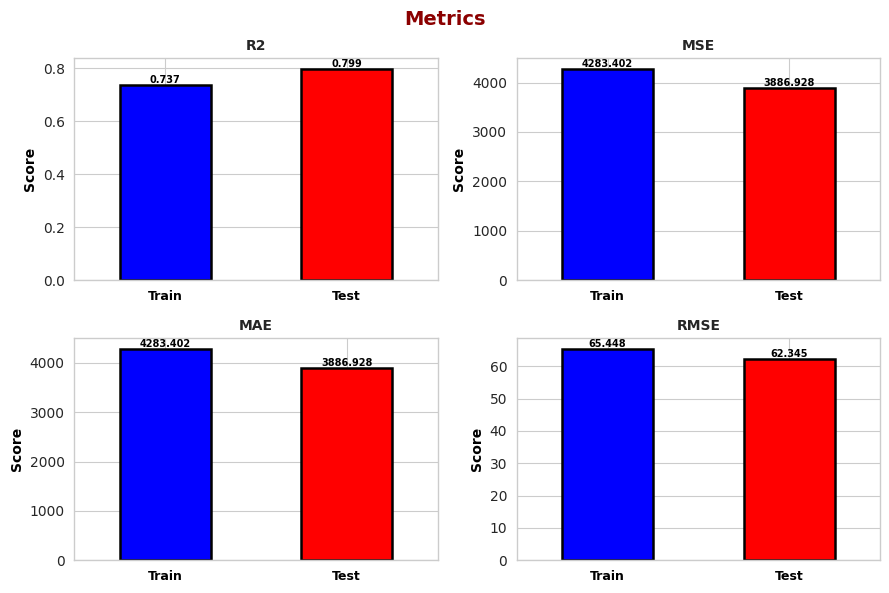

In [65]:
# Metrics plot
metrics_plot(my_metrics_train_lr, my_metrics_test_lr)

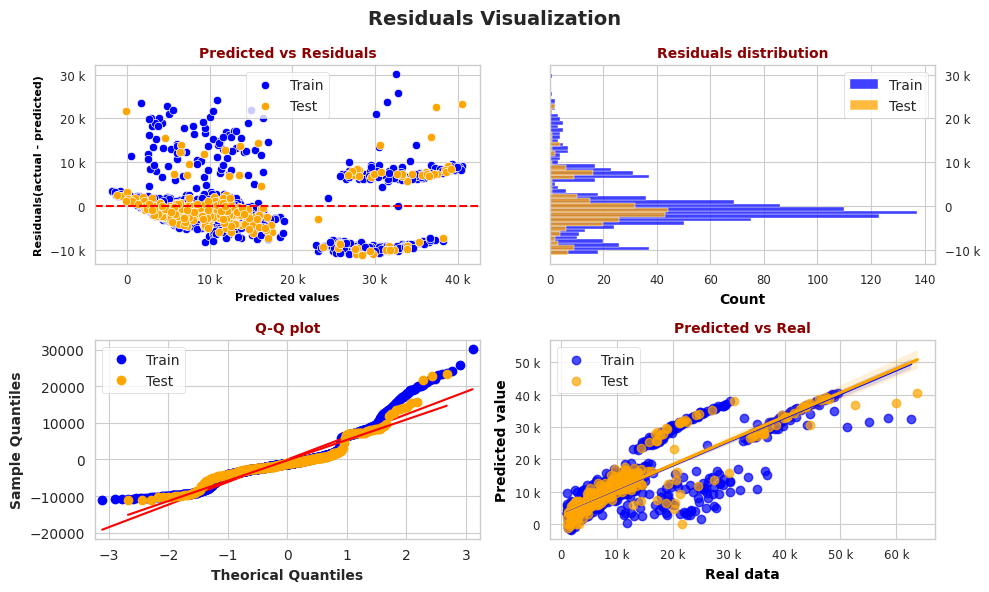

In [66]:
# Residuals plot
residuals_plot(y_train, y_test, preds_train[names[0]], preds_test[names[0]])

# **6.2 Random Forest**

In [67]:
# # we calculate the metrics of the training and test set
my_metrics_train_rf, my_metrics_test_rf = my_metrics(y_train, y_test,
                                               preds_train[names[1]], preds_test[names[1]])
print(f'Train Metrics: {my_metrics_train_rf}')
print(f'Test Metrics: {my_metrics_test_rf}')

Train Metrics: {'r2': 0.975, 'mse': 1059.966, 'mae': 1059.966, 'rmse': np.float64(32.557)}
Test Metrics: {'r2': 0.886, 'mse': 2580.907, 'mae': 2580.907, 'rmse': np.float64(50.803)}


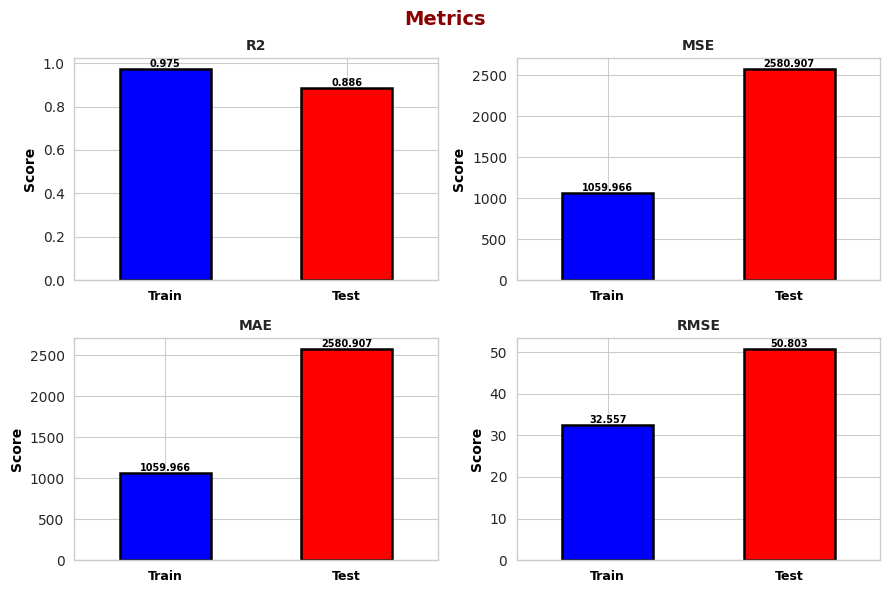

In [68]:
# Metrics plot
metrics_plot(my_metrics_train_rf, my_metrics_test_rf)

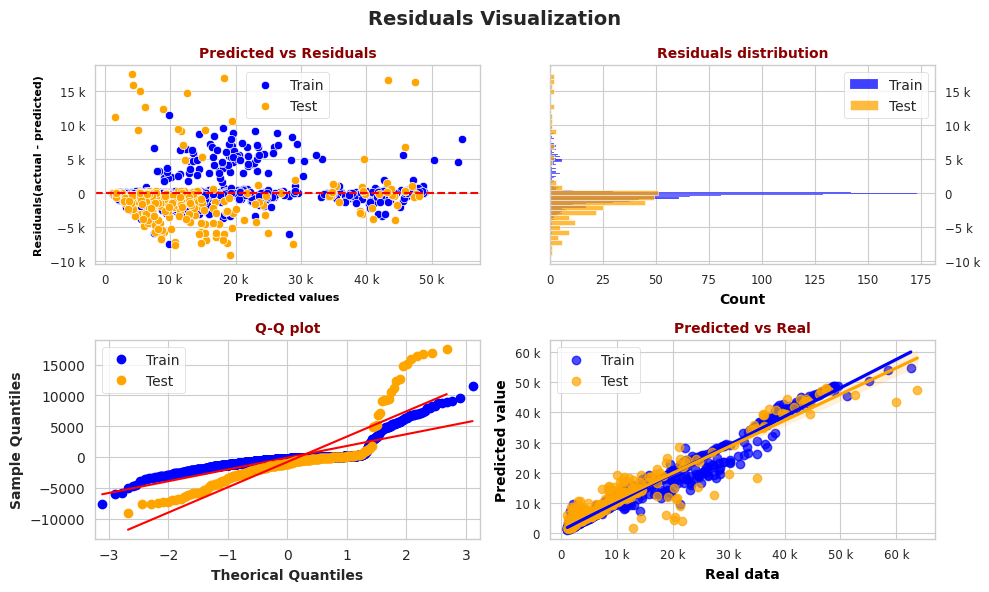

In [69]:
# Residuals plot
residuals_plot(y_train, y_test, preds_train[names[1]], preds_test[names[1]])

# **6.3 ExtraTrees**

In [70]:
# we calculate the metrics of the training and test set
my_metrics_train_et, my_metrics_test_et = my_metrics(y_train, y_test,
                                               preds_train[names[2]], preds_test[names[2]])
print(f'Train Metrics: {my_metrics_train_et}')
print(f'Test Metrics: {my_metrics_test_et}')

Train Metrics: {'r2': 0.998, 'mse': 29.6, 'mae': 29.6, 'rmse': np.float64(5.441)}
Test Metrics: {'r2': 0.873, 'mse': 2439.622, 'mae': 2439.622, 'rmse': np.float64(49.393)}


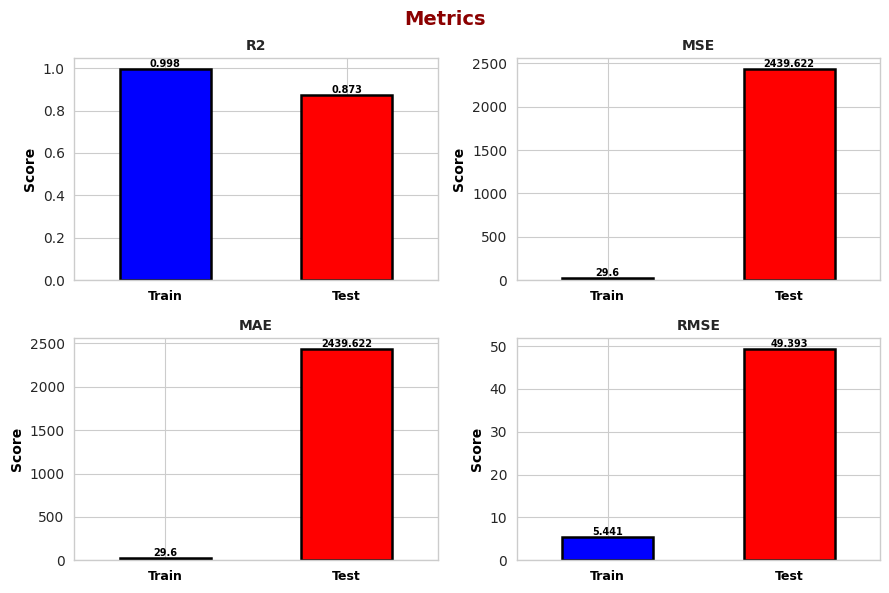

In [71]:
# Metrics plot
metrics_plot(my_metrics_train_et, my_metrics_test_et)

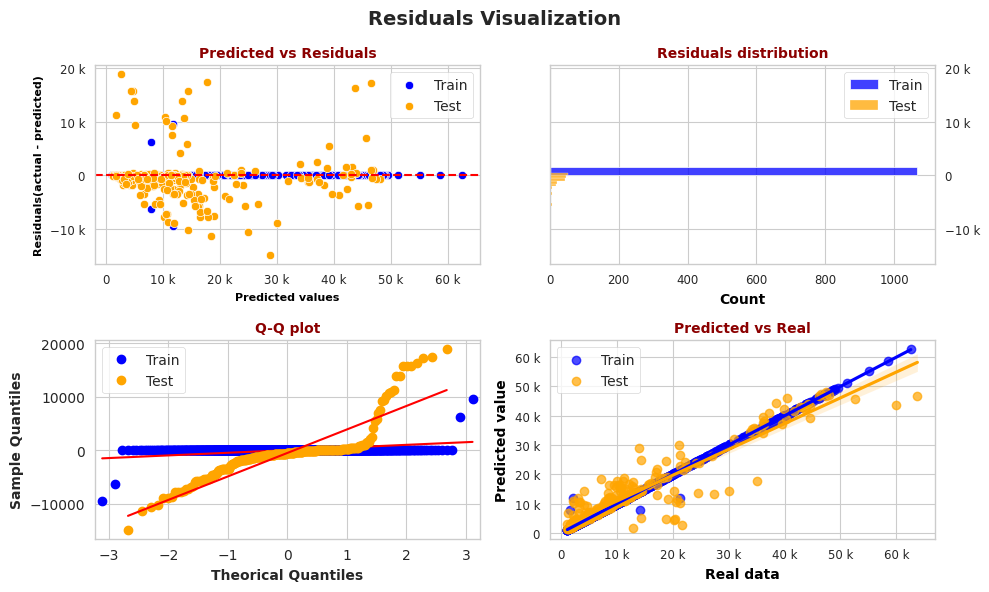

In [72]:
# Residuals plot
residuals_plot(y_train, y_test, preds_train[names[2]], preds_test[names[2]])

# **7. Compare Models**

In [73]:
def compare_metric(total_metrics_train:List[dict], total_metrics_test:List[dict], total_names:List[str], metric:str)->None:

  df_train_metrics = pd.DataFrame(data = total_metrics_train,
                                  index = total_names)

  df_test_metrics = pd.DataFrame(data = total_metrics_test,
                                 index = total_names)


  x = np.arange(len(df_train_metrics.index))
  width = 0.25

  fig,ax = plt.subplots(figsize=(10,3.5))

  # Bar chart for Training set
  rects1 = ax.bar(x-width/2, df_train_metrics.loc[:,metric], width, label = 'Train', edgecolor = 'black', linewidth = 1.3, color = 'red')
  # Bar chart for Testing set
  rects2 = ax.bar(x+width/2, df_test_metrics.loc[:,metric], width, label = 'Test', edgecolor = 'black', linewidth = 1.3, color = 'blue')

  ax.set_title(f'Metric to compare: {metric.upper()}', fontsize = 12, fontweight = 'bold', color = 'darkred')
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.set_ylabel('Score', fontsize = 10, fontweight = 'bold', color = 'black')
  ax.set_xticks(x)
  ax.set_xticklabels(df_train_metrics.index, fontsize = 9, fontweight = 'bold', color = 'black')
  ax.legend()

  def autolabel(rects):
    for rect in rects:
      height = rect.get_height()
      ax.annotate('{}'.format(height),
                  xy = (rect.get_x() + rect.get_width()/2, height),
                  xytext = (0,3),
                  textcoords = 'offset points',
                  ha = 'center',
                  va = 'bottom',
                  size = 7,
                  weight = 'bold',
                  color = 'black')

  autolabel(rects1)
  autolabel(rects2)
  fig.show()

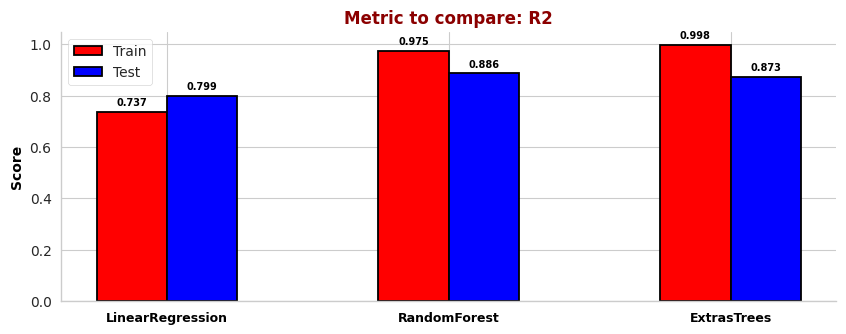

In [74]:
compare_metric([my_metrics_train_lr, my_metrics_train_rf, my_metrics_train_et],
               [my_metrics_test_lr, my_metrics_test_rf, my_metrics_test_et],
               [names[0], names[1], names[2]],
               'r2')

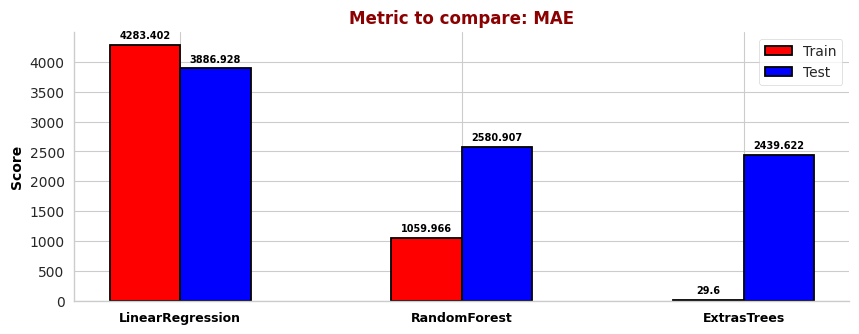

In [75]:
compare_metric([my_metrics_train_lr, my_metrics_train_rf, my_metrics_train_et],
               [my_metrics_test_lr, my_metrics_test_rf, my_metrics_test_et],
               [names[0], names[1], names[2]],
               'mae')

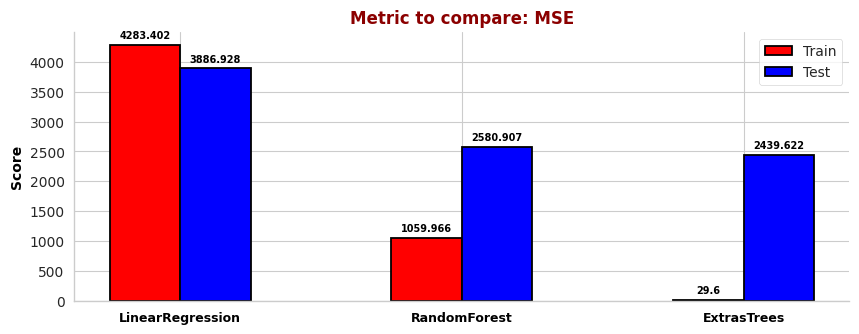

In [76]:
compare_metric([my_metrics_train_lr, my_metrics_train_rf, my_metrics_train_et],
               [my_metrics_test_lr, my_metrics_test_rf, my_metrics_test_et],
               [names[0], names[1], names[2]],
               'mse')

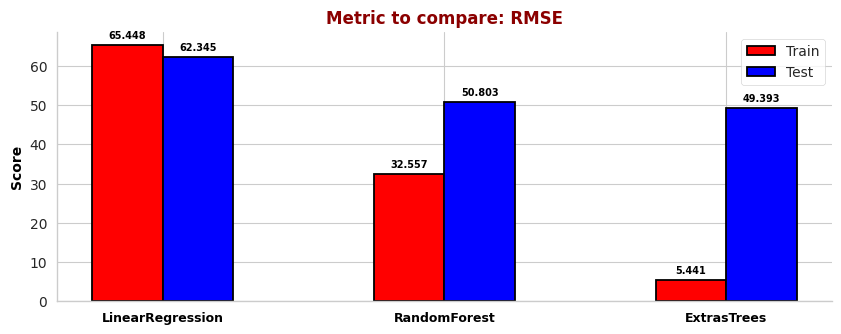

In [77]:
compare_metric([my_metrics_train_lr, my_metrics_train_rf, my_metrics_train_et],
               [my_metrics_test_lr, my_metrics_test_rf, my_metrics_test_et],
               [names[0], names[1], names[2]],
               'rmse')